In [53]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization, Cropping2D

import keras

import os
from glob import glob, iglob
from typing import List, Tuple, Union
import enum

import matplotlib.pyplot as plt
import numpy as np

In [41]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [62]:
IMG_HEIGHT =[512,256,224][2]
IMG_WIDTH  = [512,256,224][2]
IMG_CHANNELS = 3
NUM_CLASSES = 5
BATCH_SIZE = 14

DATA_DIR = "dataset"

def read_image(image_path:str) -> tf.Tensor:
    '''
    Read image from its path. Returns a tensor.
    '''

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=IMG_CHANNELS)
    image.set_shape([None, None, IMG_CHANNELS])
    image = tf.image.resize(images=image, size=[IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image, dtype=tf.uint8)

    return image


def read_mask(mask_path:str, num_classes:int=NUM_CLASSES):
    '''
    Read mask from its path. Returns a hot encoded tensor
    '''
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(images=mask, size=[IMG_WIDTH, IMG_HEIGHT])
    mask = tf.cast(mask, dtype=tf.uint8)
    # Other classified as number 8 (check)
    if num_classes > 1:
        mask = tf.squeeze(mask,axis=2) #remove extra axis
        mask = tf.one_hot(mask, depth = num_classes)
        
    return mask

def load_data(image_list:List[str], mask_list:List[str]) -> Tuple[tf.Tensor,tf.Tensor]:
    '''
    Auxiliar function to read both image and mask
    '''
    image = read_image(image_list)
    mask = read_mask(mask_list)
    return image, mask

def data_generator(image_list:List[str], mask_list:List[str],batch_size:int=BATCH_SIZE) -> tf.data.Dataset:
    '''
    Return a dataset from a list of images paths
    '''
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

train_dataset = data_generator(
    sorted(glob('dataset/augmented_images_train/*.jpg')),#+glob('dataset/train/*.jpg')),
    sorted(glob('dataset/augmented_masks_train/*.png')),#+glob('dataset/masks/*.jpg')),
)
val_dataset = data_generator(
    sorted(glob('dataset/augmented_images_val/*.jpg')),
    sorted(glob('dataset/augmented_masks_val/*.png')),
)

# Ading class weights
class_weights = tf.constant([1,1,2,1,0.95])#tf.constant([1,1,5,1,0.8])
def map_weights(image, label):
    # Assuming label is one-hot encoded, calculate weights based on the class
    weights = tf.reduce_sum(label * class_weights, axis=-1)  # Calculate weights based on class
    return image, label, weights

# Map the function to the dataset
train_dataset = train_dataset.map(map_weights)



print("Train Dataset:  ", train_dataset)
print("Val Dataset:  ", val_dataset)
# # print("Test Dataset:  ", test_dataset)

Train Dataset:   <_MapDataset element_spec=(TensorSpec(shape=(14, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(14, 224, 224, 5), dtype=tf.float32, name=None), TensorSpec(shape=(14, 224, 224), dtype=tf.float32, name=None))>
Val Dataset:   <_BatchDataset element_spec=(TensorSpec(shape=(14, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(14, 224, 224, 5), dtype=tf.float32, name=None))>


# Model

In [ ]:
conv_side = 3
conv_trans_side = 3
conv_trans_strides_side = 2
pool_side = 2

def multi_unet_model(n_classes:int=NUM_CLASSES, img_height:int=IMG_HEIGHT, img_width:int=IMG_WIDTH, img_channels:int=IMG_CHANNELS) -> keras.models.Model:
    '''
    Build the model
    '''
    inputs = keras.layers.Input((img_height, img_width, img_channels))
    s = keras.layers.Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand

    #Contraction path
    c1 = keras.layers.Conv2D(16, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = keras.layers.Dropout(0.1)(c1)
    c1 = keras.layers.Conv2D(16, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D((pool_side, pool_side))(c1)
    b1 = tf.keras.layers.BatchNormalization(synchronized=True)(p1)
    
    c2 = keras.layers.Conv2D(32, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(b1)
    c2 = keras.layers.Dropout(0.1)(c2)
    c2 = keras.layers.Conv2D(32, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D((pool_side, pool_side))(c2)
    b2 = tf.keras.layers.BatchNormalization(synchronized=True)(p2)
     
    c3 = keras.layers.Conv2D(64, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(b2)
    c3 = keras.layers.Dropout(0.2)(c3)
    c3 = keras.layers.Conv2D(64, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D((pool_side, pool_side))(c3)
    b3 = tf.keras.layers.BatchNormalization(synchronized=True)(p3)
     
    c4 = keras.layers.Conv2D(128, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(b3)
    c4 = keras.layers.Dropout(0.2)(c4)
    c4 = keras.layers.Conv2D(128, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D(pool_size=(pool_side, pool_side))(c4)
    b4 = tf.keras.layers.BatchNormalization(synchronized=True)(p4)
     
    c5 = keras.layers.Conv2D(256, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(b4)
    c5 = keras.layers.Dropout(0.3)(c5)
    c5 = keras.layers.Conv2D(256, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = keras.layers.Conv2DTranspose(128, (conv_trans_side, conv_trans_side), strides=(conv_trans_strides_side, conv_trans_strides_side), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(128, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = keras.layers.Dropout(0.2)(c6)
    c6 = keras.layers.Conv2D(128, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    b6 = tf.keras.layers.BatchNormalization(synchronized=True)(c6)
     
    u7 = keras.layers.Conv2DTranspose(64, (conv_trans_side, conv_trans_side), strides=(conv_trans_strides_side, conv_trans_strides_side), padding='same')(b6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(64, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = keras.layers.Dropout(0.2)(c7)
    c7 = keras.layers.Conv2D(64, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    b7 = tf.keras.layers.BatchNormalization(synchronized=True)(c7)
    
    u8 = keras.layers.Conv2DTranspose(32, (conv_trans_side, conv_trans_side), strides=(conv_trans_strides_side, conv_trans_strides_side), padding='same')(b7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(32, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = keras.layers.Dropout(0.1)(c8)
    c8 = keras.layers.Conv2D(32, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    b8 = tf.keras.layers.BatchNormalization(synchronized=True)(c8)
     
    u9 = keras.layers.Conv2DTranspose(16, (conv_trans_side, conv_trans_side), strides=(conv_trans_strides_side, conv_trans_strides_side), padding='same')(b8)
    u9 = keras.layers.concatenate([u9, c1], axis=3)
    c9 = keras.layers.Conv2D(16, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = keras.layers.Dropout(0.1)(c9)
    c9 = keras.layers.Conv2D(16, (conv_side, conv_side), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    
    return model
 

In [ ]:
model = multi_unet_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.OneHotIoU(
            num_classes=NUM_CLASSES,
            target_class_ids=[i for i in range(NUM_CLASSES)],
            sparse_y_pred = False # when false retrive prediction with tf.argmax
        ),
    ]
#     loss_weights=None,
#     weighted_metrics=None,
#     run_eagerly=None,
#     steps_per_execution=None,
#     jit_compile=None,
)


# Model 2

In [ ]:

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = BatchNormalization()(x)
    return x

def unet_multiclass_model_with_skip_connections(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 512)

    # Decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = conv_block(up5, 256)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 128)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model = unet_multiclass_model_with_skip_connections((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),NUM_CLASSES)

# Model 3 (VGG16 feautre extractor + decoder)

In [ ]:
VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3)).summary()

In [29]:
def conv_block(inputs,num_filters):
  x = Conv2D(num_filters,3,padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(num_filters,3,padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x) 
  
  return x

def define_decoder(inputs,skip_layer,num_filters):
  x = Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same',kernel_initializer='he_normal')(inputs) 
  g = Concatenate()([x,skip_layer])
  g = conv_block(g,num_filters)
  return g

def create_vgg_decoder(input_shape, num_classes):
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(base_model.output)
    #up5 = Concatenate(3)([up5, base_model.get_layer('block3_conv3').output])
    conv5 = conv_block(up5, 256)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    #up6 = Concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 128)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    #up7 = Concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Create the model
    model = Model(inputs=base_model.input, outputs=outputs)

    # Optionally, you can freeze the encoder layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

def vgg16_unet(input_shape,num_classes):
  inputs = Input(shape=input_shape)
  vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)  # We will extract encoder layers based on their output shape from vgg16 model

  for layer in vgg16.layers:
    layer.trainable = False

  s1 = vgg16.get_layer('block1_conv2').output  
  s2 = vgg16.get_layer('block2_conv2').output  
  s3 = vgg16.get_layer('block3_conv3').output  
  s4 = vgg16.get_layer('block4_conv3').output    # bottleneck/bridege layer from vgg16
  b1 = vgg16.get_layer('block5_conv3').output #32
  
  # Decoder Block
  d1 = define_decoder(b1,s4,512)
  d2 = define_decoder(d1,s3,256)
  d3 = define_decoder(d2,s2,128)
  d4 = define_decoder(d3,s1,64)  #output layer
  outputs = Conv2D(num_classes,1,padding='same',activation='softmax')(d4)
  model = Model(inputs,outputs)
  
  return model


In [30]:
model = vgg16_unet((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), NUM_CLASSES)

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

# Train

In [55]:
model.compile(
    optimizer=Adam(
        learning_rate = 1e-5,
        beta_1 = .99,
        beta_2 = .999
    ),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.OneHotIoU(
            
            num_classes=NUM_CLASSES,
            target_class_ids=[i for i in range(NUM_CLASSES)],
            sparse_y_pred = False # when false retrive prediction with tf.argmax
        ),
    ]
)


In [56]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=6,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
#         verbose=0,
        mode='auto',
        min_delta=0.0001,
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='logs'
    ),
    tf.keras.callbacks.History(
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join('models','checkpoints','Checkpoint.model.keras'),
        monitor='val_loss',
        verbose=2,
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch',
        initial_value_threshold=None
    ),
    tf.keras.callbacks.BackupAndRestore(
        os.path.join('models','checkpoints','BackupCheckpoint.model.keras'),
        save_freq='epoch',
        delete_checkpoint=True
    )
]

In [63]:
history = model.fit(
    x=train_dataset,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
    validation_data=val_dataset,
    shuffle=True,
    initial_epoch=50,
)
# Run 1:   237 m 33.2 s 39 epochs, 39 epochs
# Run 1.1:   6 m 67.4 s  1 epochs, 40 epochs
# Run 2:    53 m  1.3 s 10 epochs, 50 epochs
# Run 3


Epoch 51/100

Epoch 51: val_loss improved from inf to 0.22208, saving model to models/checkpoints/Checkpoint.model.keras
272/272 - 371s - loss: 0.1015 - one_hot_io_u_2: 0.7284 - val_loss: 0.2221 - val_one_hot_io_u_2: 0.6137 - lr: 1.0000e-04 - 371s/epoch - 1s/step
Epoch 52/100

Epoch 52: val_loss did not improve from 0.22208
272/272 - 307s - loss: 0.0997 - one_hot_io_u_2: 0.7384 - val_loss: 0.2243 - val_one_hot_io_u_2: 0.6149 - lr: 1.0000e-04 - 307s/epoch - 1s/step
Epoch 53/100

Epoch 53: val_loss did not improve from 0.22208
272/272 - 308s - loss: 0.0988 - one_hot_io_u_2: 0.7394 - val_loss: 0.2250 - val_one_hot_io_u_2: 0.6129 - lr: 1.0000e-04 - 308s/epoch - 1s/step
Epoch 54/100

Epoch 54: val_loss did not improve from 0.22208
272/272 - 308s - loss: 0.0968 - one_hot_io_u_2: 0.7436 - val_loss: 0.2242 - val_one_hot_io_u_2: 0.6132 - lr: 1.0000e-04 - 308s/epoch - 1s/step
Epoch 55/100


KeyboardInterrupt: 

In [64]:
model.save('models/VGG16unet-224x224-54epochs.model.keras')

In [50]:
history.history.keys()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['val_loss'],'r-', label='Validation Loss')
plt.plot(history.history['loss'],'r--', label='Loss')
plt.plot(history.history['one_hot_io_u'],'b--',label='IoU')
plt.plot(history.history['val_one_hot_io_u'],'b-',label='Validation IOU')

plt.xlabel('Epochs')
plt.xlim(0)
plt.ylim(0)
plt.legend()

In [37]:
def color_map(mask:tf.Tensor) -> np.ndarray:
    '''
    Turn an 1-encoded gray image into a colored image
    '''
    background_color = (0,0,0) # black
    clear_sky = (92, 179, 255) # clear blue
    thin_cloud = (255, 243, 245) # shiny gray
    tick_cloud = (113, 125, 150) # deep gray
    sun = (255, 242, 0) # yellow
    
    colored_image = np.empty((mask.shape[0],mask.shape[1],3),dtype=np.uint8)
    
    
    for class_index, color in enumerate([background_color,clear_sky,sun,tick_cloud,thin_cloud]):
        indices = np.where(mask == class_index)
        colored_image[indices[0],indices[1],:] = color
    return colored_image

def multipredict(img_list:List[str],mask_list:List[str],model:keras.Model=model) -> None:
    if len(img_list) != len(mask_list):
        raise ValueError('There must be the same number os masks and images')
    if len(img_list) == 0:
        raise ValueError('There must be at least one image')
    
    fig, ax = plt.subplots(len(img_list),3,figsize=(12,4*len(img_list)+3))
    index = 0 # row counter
    for img_path, mask_path in zip(img_list,mask_list):
        img = read_image(img_path)
        ax[index,0].imshow( img )
        ax[index,0].set_xticks([])
        ax[index,0].set_yticks([])
        
        pred = model.predict( tf.expand_dims(img,0) )
        ax[index,1].imshow( color_map(tf.argmax(pred[0,:,:,:],2)) )
        ax[index,1].set_xticks([])
        ax[index,1].set_yticks([])
        
        ax[index,2].imshow(color_map(read_image(mask_path)[:,:,0]))
        ax[index,2].set_xticks([])
        ax[index,2].set_yticks([])
        
        index += 1
    
    ax[0,0].set_title("Image")
    ax[0,1].set_title("Inference")
    ax[0,2].set_title("Ground truth")

In [38]:
test_images = [os.path.join('dataset','images',name.strip()) for name in open('dataset/test.txt').readlines()]
test_masks = [os.path.join('dataset','masks',name.strip()) for name in open('dataset/test.txt').readlines()]

1/1 [==============================] - 0s 26ms/step


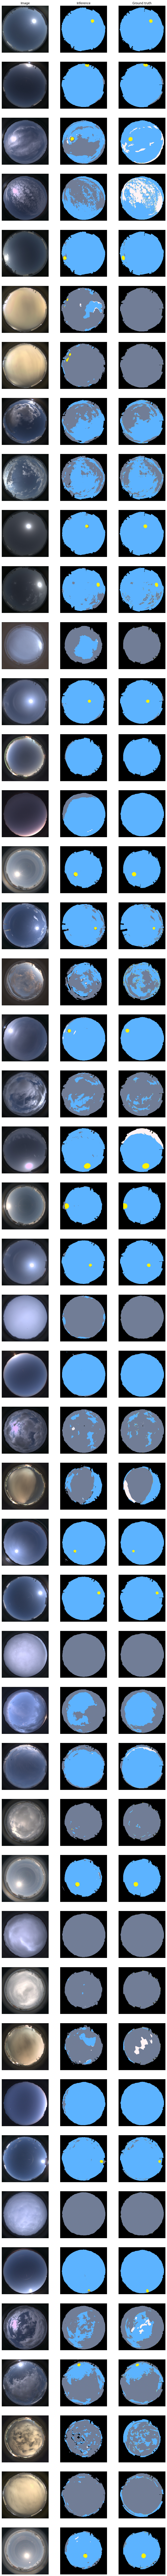

In [51]:
multipredict(test_images,test_masks)
plt.savefig("VGG16unet-224x224-50epochs.jpg")